In [6]:
# =====================================================================
# IMPORT LIBRARIES
# =====================================================================
import pandas as pd
import numpy as np
import math
from random import seed
from random import randrange
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  

In [4]:
import sys
sys.path

['',
 'C:\\Program Files\\Anaconda3\\python36.zip',
 'C:\\Program Files\\Anaconda3\\DLLs',
 'C:\\Program Files\\Anaconda3\\lib',
 'C:\\Program Files\\Anaconda3',
 'C:\\Program Files\\Anaconda3\\lib\\site-packages',
 'C:\\Program Files\\Anaconda3\\lib\\site-packages\\Babel-2.5.0-py3.6.egg',
 'C:\\Program Files\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Program Files\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Program Files\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Program Files\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Trish\\.ipython',
 'C:\\Program Files\\Python36\\python36.zip',
 'C:\\Program Files\\Python36\\DLLs',
 'C:\\Program Files\\Python36\\lib',
 'C:\\Program Files\\Python36',
 'C:\\Program Files\\Python36\\lib\\site-packages']

In [3]:
sys.path.append('C:\\Program Files\\Python36\\python36.zip')
sys.path.append('C:\\Program Files\\Python36\\DLLs')
sys.path.append('C:\\Program Files\\Python36\\lib')
sys.path.append('C:\\Program Files\\Python36')
sys.path.append('C:\\Program Files\\Python36\\lib\\site-packages')

Utility Functions

In [7]:
def getFile(myFile):
    # Read files
    myData = pd.read_csv(myDataPath + myFile)
    return myData

def plotCleanup():
    # print(plt.get_fignums())
    plt.close('all')

def smoteMe(X,y, ymod):
    print("SMOTEing...")
    Xs=X.shape[1]
    
    # check original shape
    print('Original dataset shape: ')
    print(y.shape)
    # concatenate X and y
    try:
        Xy = np.concatenate((X,y), axis=1)
    except:
        Xy = pd.concat([X,y], axis=1)
    print('New Xy shape')
    print(Xy.shape)
    # Use the mode to balance (as array)
    ymodarr = np.ravel(ymod.as_matrix(columns=ymod.columns[0:]))
    try:
        Xy_res, ymodarr_res = SMOTE().fit_sample(Xy, ymodarr)
    except:        
        Xy_res, ymodarr_res = SMOTE(k_neighbors=2).fit_sample(Xy, ymodarr)
    # Restore X columns
    X_res = Xy_res[:,0:Xs]
    y_res = Xy_res[:,Xs:Xy_res.shape[1]]
    print('Resampled dataset shape: ')
    print(y_res.shape)
    return X_res, y_res 

def prepData(X, y, ymod, smoteFlag): 
    # SMOTE
    if smoteFlag==True:    # this doesn't work, yet           
        X, y = smoteMe(X, y, ymod)
    else:
        pass
    # Min-Max Normalization     
    Xtrans = MinMaxScaler().fit_transform(X)
    return Xtrans, y

def plotMe(maxK, scores, names, title, metr):
    if metr == 'MSE':        
        plotCleanup()   
        sns.set(style="white")    
        plt.figure() 
        for name, score in zip(names, scores):
            numKs = list(range(1,len(score)+1,1))
            plt.plot(numKs, score, label=name)
        plt.title(title)
        #plt.xlim(0,max(numKs))
        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Misclassification Error (MSE)')
        plt.legend()
        imgname = title.replace(" ","_")
        plt.show()
        # to save files, comment above and uncomment below
        #plt.savefig(myImagePath + 'Evaluation_' + imgname + '.png')
    elif metr == 'AUCdt':
        threshold=np.arange(0.0, 1.0, 0.05)
        plt.figure()
        lw=2
        areatest = np.trapz(scores[0],threshold)
        areatrain = np.trapz(scores[1],threshold)
        plt.plot(threshold, scores[0], label='Test: AUC curve (area = %0.2f)' % areatest)
        plt.plot(threshold, scores[1], label='Train: AUC curve (area = %0.2f)' % areatrain)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlabel('Distance Threshold Values')
        plt.ylabel('% Frequency')
        plt.title(title)
        plt.legend(loc="lower right")
        imgname = title.replace(" ","_")
        plt.show()
        # to save files, comment above and uncomment below
        # plt.savefig(myImagePath + 'Evaluation_' + imgname + '.png')

KNN Model Functions

In [8]:
## Create splits for train/test
#    X_train, X_test, y_train, y_test = train_test_split(Xtrans, y, test_size = testSize)
#    return X_train, X_test, y_train, y_test

# =====================================================================
# KNN MODEL FUNCTIONS
# =====================================================================
def modelMetrics(y_actual, y_pred, metric):
    # for development, I'm using MSE. but this function will accept alternatives
    predicted = np.array(y_pred)
    actual = np.array(y_actual)

    if metric == 'MSE':
        model_metrics = metrics.mean_squared_error(actual, predicted, multioutput='raw_values')
    elif metric == 'AUCdt':
        model_metrics = [] # create distance threshold list       
        # u is target labels
        u = y_actual
        # v is prediction labels
        v = y_pred
        m=v.shape[0] #number of samples
        p=v.shape[1] #number of labels
        dist=np.zeros(m) #create distance vector
        DTh=[] #create distance threshold list
        #compute Jeffrey_divergence Distance
        for i in range(m): # for row
            d=0
            for j in range(p): # for column
                #(A+B)/2
                q=(u[i,j]+v[i,j])/2
                # calculate label's distance between target and prediction  
                if u[i,j]==0 and v[i,j]==0:
                    d=d+0
                elif u[i,j]==0 and v[i,j]!=0:
                    d=d+0+v[i,j]*math.log(v[i,j]/q)
                elif u[i,j]!=0 and v[i,j]==0:
                    d=d+u[i,j]*math.log(u[i,j]/q)+0
                else:
                    d=d+u[i,j]*math.log(u[i,j]/q)+v[i,j]*math.log(v[i,j]/q)
            
            dist[i]=d #add the distance to the distance vector
        #compute distance-threshold
        threshold=np.arange(0.0, 1.0, 0.05)
        for x in threshold:
            dt=0
            for i in range(dist.shape[0]):
                if dist[i] <= x: #compared the distance with threshold 
                    dt=dt+1
                else:
                    dt=dt
            DTh = np.append(DTh,dt/dist.shape[0]) # add threshold to threshold list
        model_metrics = DTh                      
    elif metric == 'hamming':
        H = np.average(y_actual * (1 - y_pred) + (1 - y_actual) * y_pred)
        model_metrics.append(H)
    else:
        pass
        #model_metrics = []
        #for i in range(0, np.shape(predicted)[1]):
        #    # this is also MSE (manual)
        #    metric = math.pow((actual[:,i] - predicted[:,i]),2)/np.shape(predicted)[0]
        #    model_metrics.append(metric)
    return model_metrics

# Compute the mean of K Neighbors
def predictValues (label_index, label_value):  
    predM = np.zeros((label_index.shape[0],label_value.shape[1])) 
    # Create a predict zero matrix 
    for i in range(label_index.shape[0]):        
        neighborM = np.zeros((label_index.shape[1],label_value.shape[1])) 
        # Create a neighbor matrix for a predict instance
        for j in range(label_index.shape[1]):            
            neighborM[j,:] = label_value[label_index[i,j],:] 
            label_value[label_index[i,j],:] 
            # Add neigbor value to the neighbor matrix
            j = j + 1
        predV = np.mean(neighborM, axis=0) 
        # Compute the mean of neighbors and get the predict vector for an instance
        predM[i,:] = predV #Add the predict vector to predict matrix
        i = i + 1
    return predM # Return the Predict Matrix

def knnTuning(metr, X, y, mode, maxK, folds, smoteFlag, name, pct_diff): 
    X, y = prepData(X, y, mode, smoteFlag)    
    # make function that returns the optimal k     
    nnCVScores = [] 
    nnCVmeanscores =[]
    nnCVk_opt = 0
    nnCV_opt = 10.0 
    X = np.array(X)
    y = np.array(y)
    # get indices for splits
    kf = KFold(n_splits=folds)
    if maxK < 51:
        step = 2
    elif maxK < 101:
        step = 4
    elif maxK < 501:
        step = 50
    else:
        step = 100
    numKs = list(range(2,maxK,step))
    print('Tuning for K')
    for k in numKs:        
        model_metrics = []
        cvmean = []
        nnCVScores_k = []
        knn = NearestNeighbors(n_neighbors=k)
        for train_index, test_index in kf.split(X):            
            X_train, X_test = X[train_index,], X[test_index,]
            y_train, y_test = y[train_index,], y[test_index,]
            knn.fit(X_train, y_train)
            cvNeighbors = knn.kneighbors(X_test, return_distance=True)
            label_indexes = np.matrix(cvNeighbors[1])            
            label_values = np.matrix(y_train)
            cvpredicted = predictValues (label_indexes, label_values)
            model_metrics.append(modelMetrics(y_test, cvpredicted, metr)) 
        nnCVScores.append(np.mean(model_metrics, axis = 0))
        
    #calculating for the optimal K based on percent change of MSE
        nnCVScores_k.append(np.mean(model_metrics, axis = 0))
        cvmean = [sum(x)/len(x) for x in nnCVScores_k]
        if metr == 'MSE':
            if nnCV_opt > cvmean[0]*(1+pct_diff):
                nnCV_opt = cvmean
                nnCVk_opt = k
            else: 
                pass
        elif metr == 'AUCdt':
            if nnCV_opt < cvmean[0]*(1+pct_diff):
                nnCV_opt = cvmean
                nnCVk_opt = k
            else:
                pass
        

    # determine best k for models
    numPoints = len(nnCVScores[0])
    meanMSE = [sum(x)/len(x) for x in nnCVScores] 
    low_k_mean = numKs[meanMSE.index(np.min(meanMSE))]  ## this one is the lowest mean ##
    optimal_k_mean = nnCVk_opt ## this one is based on pct diff

    print ("Optimal number of neighbors (mean) is %d" % optimal_k_mean)
    print ("Lowest number of neighbors (mean) is %d" % low_k_mean)
    print(meanMSE)
    print(len(meanMSE))
    plotCleanup()   
    sns.set(style="white")    
    fig, ax = plt.subplots(figsize=(5,4))
    if numPoints == 4:
        [a,b,c,d] = plt.plot(numKs, nnCVScores)
        labels=['class 1', 'class 2', 'class 3', 'class 4'] 
        plt.legend([a,b,c,d],labels)
    elif numPoints == 6:
        [a,b,c,d,e,f] = plt.plot(numKs, nnCVScores)
        labels=['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']
        plt.legend([a,b,c,d,e,f],labels)
    else:
        [a,b,c,d,e] = plt.plot(numKs, nnCVScores)
        labels=['class 1', 'class 2', 'class 3', 'class 4', 'class 5']   
        plt.legend([a,b,c,d,e],labels)        
    plt.title('kNN Tuning: ' + name)
    plt.xlim(0,max(numKs))
    plt.ylim(0,.3)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error (MSE)')
    plt.axvline(x=optimal_k_mean, color='r', linestyle='--')
    plt.axvline(x=low_k_mean, color='b', linestyle='--')
    plt.text(optimal_k_mean-1,0,'optimal k', color='r', fontsize=8)    
    plt.text(low_k_mean-1,0,'lowest k', color='b', fontsize=8)    
    imgname = name.replace(" ","_")
    plt.show()        
    # to save files, comment above and uncomment below
    # plt.savefig(myImagePath + 'KNN_tuning_' + imgname + '.png')
    return optimal_k_mean, meanMSE

def knnModel(k, metr, X, y, mode, maxK, folds, smoteFlag, name):
    startTime = time.time()
    # print("Start Time:",time.strftime("%H:%M:%S", time.gmtime(startTime)), sep=" ") 
    
    # X = X_train; y = y_train;
    X_smote, y_smote = prepData(X, y, mode, smoteFlag)   
    X_smote = np.array(X_smote)
    y_smote = np.array(y_smote)
    X=np.array(X)
    Y_sub=np.array(y)

    knnTestScores = []
    knnTrainScores = []
    # get indices for splits
    kf = KFold(n_splits=folds)
    numKs = list(range(2,maxK,2))     
    test_model_metrics = []
    train_model_metrics = []
    all_model_metrics = []

    knn = NearestNeighbors(n_neighbors=k)
    
    print('Running Model for ' + name)  
    for train_index, test_index in kf.split(X_smote):
        X_train, X_test = X_smote[train_index,], X_smote[test_index,]
        y_train, y_test = y_smote[train_index,], y_smote[test_index,]
        knn.fit(X_train, y_train)

        # train
        trainNeighbors = knn.kneighbors(X_train, return_distance=True)
        train_indexes = np.matrix(trainNeighbors[1])
        train_values = np.matrix(y_train)
        trainPredicted = predictValues (train_indexes, train_values)
        train_model_metrics.append(modelMetrics(y_train, trainPredicted, metr)) 

        # test
        testNeighbors = knn.kneighbors(X_test, return_distance=True)
        test_indexes = np.matrix(testNeighbors[1])
        test_values = np.matrix(y_train)
        testPredicted = predictValues (test_indexes, test_values)
        test_model_metrics.append(modelMetrics(y_test, testPredicted, metr))  
    
    knnTestScores.append(np.mean(test_model_metrics, axis = 0))
    knnTrainScores.append(np.mean(train_model_metrics, axis = 0))
    
    # Print Elapsed Time
    endTime = time.time()
    # print("End Time:",time.strftime("%H:%M:%S", time.gmtime(endTime)), sep=" ")  
    elapsedTime = endTime - startTime
    print("Model Runtime:",time.strftime("%H:%M:%S", time.gmtime(elapsedTime)), sep=" ") 
    
    # all for second cascade
    allNeighbors = knn.kneighbors(X, return_distance=True)
    all_indexes = np.matrix(allNeighbors[1])
    all_values = np.matrix(y_train)
    allPredicted = predictValues (all_indexes, all_values)
    # all_model_metrics.append(modelMetrics(y, allPredicted, metr))  

    if metr == 'MSE':
        scoreTest = [sum(x)/len(x) for x in knnTestScores]
        scoreTrain = [sum(x)/len(x) for x in knnTrainScores]
    elif metr == 'AUCdt':
        threshold=np.arange(0.0, 1.0, 0.05)
        scoreTest = np.trapz(knnTestScores,threshold)       
        scoreTrain = np.trapz(knnTrainScores,threshold)
    print('Train Score:')    
    print(scoreTrain)
    print('Test Score:')
    print(scoreTest)    
    return scoreTest, scoreTrain, allPredicted, knnTestScores, knnTrainScores

Set Processing Variables

In [15]:
# =====================================================================
# SET PROCESSING VARIABLES 
# =====================================================================
global myDataPath, projectPath, myImagePath

# File Paths
projectPath = "/Users/emmadu/Downloads/"
myDataPath = projectPath + "Data/"
myImagePath = projectPath + "Images/"

smoteFlag = False   # If True, then it will apply SMOTE to X, y using smoteMe(X,y)
folds = 5      # Sets default folds = 10 for KNN_tuning
maxK = 50      # Sets default maxK for KNN_tuning
metric = 'MSE'  # Sets default metric to use
testSize = .3   # Sets default test split size
k =2            # Sets default k neighbors
pct_diff = .1   #Sets percent change in MSE when selecting K

Get Data Sets

In [16]:
# =====================================================================
# GET DATA SETS
# label prefixes - c: rater counts; p: probabilistic; pw: probabilistic weighted
# =====================================================================
# Data Set A for Base Model
fDatasetCols = 'MaxSlices_cols.csv'
DataSet = getFile(fDatasetCols)
list(DataSet)

# Model Column Lists
semanticFeatures = ['Malignancy','Subtlety','Sphericity','Margin',
                    'Lobulation','Spiculation','Texture','InternalStructure','Calcification']
cSemanticFeatures=[]; pSemanticFeatures=[]; pwSemanticFeatures=[]; mSemanticFeatures=[];

for label in semanticFeatures:
    if label=='InternalStructure':
        numScores = 4
    elif label=='Calcification':
        numScores = 6
    else:
        numScores = 5

    # initialize label lists
    cLabels = []; pLabels = []; pwLabels = [];
        
    for i in range(1,numScores+1):
        cLabels.append('c' + label + str(i))
        pLabels.append('p' + label + str(i))
        pwLabels.append('pw'+ label + str(i))
    
    if label == 'Malignancy':
        cMalignancyFeatures = cLabels
        pMalignancyFeatures = pLabels
        pwMalignancyFeatures = pwLabels
        mMalignancyFeatures = 'm' + label
    else:
        cSemanticFeatures = cSemanticFeatures + [cLabels]
        pSemanticFeatures = pSemanticFeatures + [pLabels]
        pwSemanticFeatures = pwSemanticFeatures + [pwLabels]
        mSemanticFeatures.append('m' + label)
       
semanticFeatures.pop(0) # This removes Malignancy from the list

'Malignancy'

Setup data sets for models

In [17]:
# =====================================================================
# SETUP DATA SETS FOR MODELS
# =====================================================================
mSemantic = dict(); cSemantic = dict(); pSemantic = dict(); pwSemantic = dict();

# Modes
mMalignancy = DataSet.filter(regex=mMalignancyFeatures)

for feature, featureset in zip(semanticFeatures, mSemanticFeatures):
    mSemantic[feature] = DataSet.filter(regex=featureset)
    
# Counts by Rater (c)
cMalignancy = pd.DataFrame(DataSet, columns=cMalignancyFeatures)
for feature, featureset in zip(semanticFeatures, cSemanticFeatures):
    cSemantic[feature] = pd.DataFrame(DataSet, columns=featureset)

# Probabilistic Values (p)
pMalignancy = pd.DataFrame(DataSet, columns=pMalignancyFeatures)
for feature, featureset in zip(semanticFeatures, pSemanticFeatures):
    pSemantic[feature] = pd.DataFrame(DataSet, columns=featureset)

# Probabilistic Weighted (pw)
pwMalignancy = pd.DataFrame(DataSet, columns=pwMalignancyFeatures)

for feature, featureset in zip(semanticFeatures, pwSemanticFeatures):
    pwSemantic[feature] = pd.DataFrame(DataSet, columns=featureset)

# Image Features
imageCols = "Area|ConvexArea|Perimeter|ConvexPerimeter|EquivDiameter|MajorAxisLength|MinorAxisLength|Elongation|Compactness|Eccentricity|Solidity|Extent|Circularity|RadialDistanceSD|Roughness|MinIntensity|MaxIntensity|MeanIntensity|SDIntensity|MinIntensityBG|MaxIntensityBG|MeanIntensityBG|SDIntensityBG|IntensityDifference|markov1|markov2|markov3|markov4|markov5|gabormean_0_0|gaborSD_0_0|gabormean_0_1|gaborSD_0_1|gabormean_0_2|gaborSD_0_2|gabormean_1_0|gaborSD_1_0|gabormean_1_1|gaborSD_1_1|gabormean_1_2|gaborSD_1_2|gabormean_2_0|gaborSD_2_0|gabormean_2_1|gaborSD_2_1|gabormean_2_2|gaborSD_2_2|gabormean_3_0|gaborSD_3_0|gabormean_3_1|gaborSD_3_1|gabormean_3_2|gaborSD_3_2|Contrast|Correlation|Energy|Homogeneity|Entropy|x_3rdordermoment|Inversevariance|Sumaverage|Variance|Clustertendency|MaxProbability"
ImageFeatures = DataSet.filter(regex=imageCols)

# X=ImageFeatures; y=pMalignancy; mode=mMalignancy;
# X_train, X_test, y_train, y_test = prepData(X, y, mode, .3, 0)

# =====================================================================
# Set up different line styles for plots - up to 8 line styles
# =====================================================================
plot_args = [{'c': 'red', 'linestyle': '-'},{'c': 'green', 'linestyle': '-'},{'c': 'blue', 'linestyle': '-'},{'c': 'black', 'linestyle': '-'},{'c': 'red', 'linestyle': '--'},{'c': 'green', 'linestyle': '--'},{'c': 'blue', 'linestyle': '--'},{'c': 'black', 'linestyle': '--'}]

Tuning for K
Optimal number of neighbors (mean) is 10
Lowest number of neighbors (mean) is 38
[0.096864190454615959, 0.08166823639230554, 0.076861818874230228, 0.075114707081961107, 0.073835083978700991, 0.073145013263585981, 0.072605987686317694, 0.071998509812464334, 0.071646657723292859, 0.071275076708720311, 0.071047724732444292, 0.070737891632450603, 0.070460766302623906, 0.07043130954713675, 0.070463774493384423, 0.070449115152094746, 0.070386820026259025, 0.070381568491546836, 0.070301093385757768, 0.070303297589434585, 0.070417340216786611, 0.070449163110990531, 0.070440316488234081, 0.07034400279399726]
24


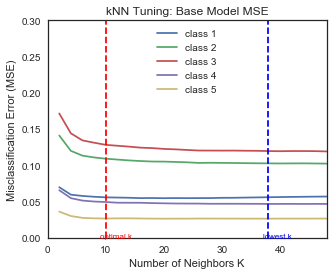

Running Model for Base Model MSE
Model Runtime: 00:00:11
Train Score:
[0.059505165820303588]
Test Score:
[0.073835083978700991]
SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Tuning for K
Optimal number of neighbors (mean) is 2
Lowest number of neighbors (mean) is 2
[0.054393630847922717, 0.059784086675296423, 0.063483779968789303, 0.065580243768076418, 0.066896934191980645, 0.067844838483884534, 0.068620425396032692, 0.06923738455513774, 0.06962872513460687, 0.070084057518482484, 0.07035695181242882, 0.070753283535337011, 0.070910364301040169, 0.071131985278683058, 0.071339378887724375, 0.071533705792832025, 0.071732280747396043, 0.071739415827518166, 0.071879428181760407, 0.071970062645308752, 0.072146720066812248, 0.072210036209683956, 0.072291718206716538, 0.072377992720240522]
24


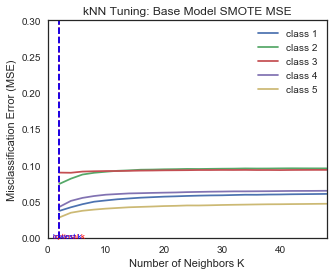

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Running Model for Base Model SMOTE MSE
Model Runtime: 00:00:20
Train Score:
[0.01215718168441526]
Test Score:
[0.055534257237831244]
Tuning for K
Optimal number of neighbors (mean) is 10
Lowest number of neighbors (mean) is 28
[0.023594575185333155, 0.019878155144320373, 0.018788492146758994, 0.018153688461669266, 0.017840913955541614, 0.017676054142767905, 0.017517008871899241, 0.017382431545535666, 0.017354967528517076, 0.017289912496320409, 0.017270909717553372, 0.017158676580271086, 0.01707949752810892, 0.017061494493597333, 0.017118568259270821, 0.01713599644916914, 0.017140510089606618, 0.017145756044833815, 0.017108743628039359, 0.017131605924543509, 0.017152506751676545, 0.017178858406390777, 0.017197403282985087, 0.017182611509268208]
24


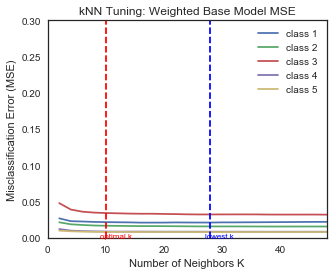

Running Model for Weighted Base Model MSE
Model Runtime: 00:00:13
Train Score:
[0.014221420152957711]
Test Score:
[0.017840913955541614]
SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Tuning for K
Optimal number of neighbors (mean) is 2
Lowest number of neighbors (mean) is 2
[0.012128295796898772, 0.013475099616656074, 0.014245009456353477, 0.01485479232686949, 0.015254079524052899, 0.015579229831840877, 0.015788612210357551, 0.016003327757807825, 0.016187355562229208, 0.016328978532618211, 0.016465993374781645, 0.016552049499589237, 0.016649861359424402, 0.016719088336998138, 0.016778845339886227, 0.016873944393354358, 0.016932923766318601, 0.01698648469280184, 0.017044716424063463, 0.017104793616861409, 0.017153605679696544, 0.017205800674477596, 0.017240072667238253, 0.01726202305980281]
24


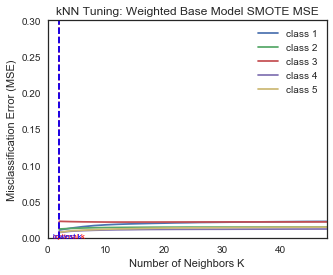

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Running Model for Weighted Base Model SMOTE MSE
Model Runtime: 00:00:19
Train Score:
[0.0028983142637578592]
Test Score:
[0.012655426897064706]


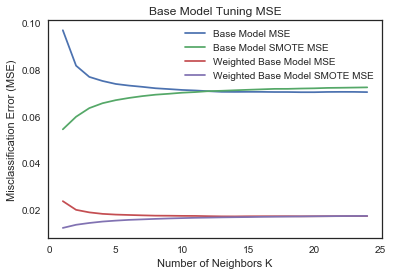

In [18]:
# =====================================================================
# BASE MODEL - MSE with tuning
# =====================================================================
# Set params for models - if you want to change parameters, change them here
metric = 'MSE'
params = [{'name': 'Base Model MSE', 'X': ImageFeatures, 'y': pMalignancy,  'mode': mMalignancy, 'smoteFlag': False},
          {'name': 'Base Model SMOTE MSE', 'X': ImageFeatures, 'y': pMalignancy, 'mode': mMalignancy, 'smoteFlag': True},    
          {'name': 'Weighted Base Model MSE', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': False},
          {'name': 'Weighted Base Model SMOTE MSE', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': True}]
names=[]
scores = []
modelnames=[]
scoresTest = []
scoresTrain = []
base_optK ={}
for param in params:
    # Tune Number of Neighbors
    k, tuningscores = knnTuning(metric, param['X'], param['y'], param['mode'], maxK, folds, param['smoteFlag'], param['name'], pct_diff)
    scores.append(tuningscores)
    names.append(param['name'])
    base_optK[param['name']]= k
    # model
    scoreTest, scoreTrain, predicted, knnTestScores, knnTrainScores = knnModel(k, metric, param['X'], param['y'], param['mode'], maxK, folds, param['smoteFlag'], param['name'])
    #scoresTest.append(scoreTest) 
    #scoresTrain.append(scoreTrain)   
    # don't need predicted here
    
plotMe(maxK, scores, names, 'Base Model Tuning ' + metric, metric)     
# plotMe(maxK, scoresTest, names, 'Base Models Test ' + metric, metric)    
# plotMe(maxK, scoresTrain, names, 'Base Models Train ' + metric, metric)


In [20]:
print("Base Model Tuning optimal K's are:")
print(base_optK)

Base Model Tuning optimal K's are:
{'Base Model MSE': 10, 'Base Model SMOTE MSE': 2, 'Weighted Base Model MSE': 10, 'Weighted Base Model SMOTE MSE': 2}


In [21]:
# =====================================================================
# BASE MODEL - MSE NO TUNING
# =====================================================================
params = [{'name': 'Base Model MSE', 'X': ImageFeatures, 
           'y': pMalignancy,  'mode': mMalignancy, 'smoteFlag': False, 'k': base_optK['Base Model MSE']},
          {'name': 'Base Model SMOTE MSE', 'X': ImageFeatures, 
           'y': pMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': base_optK['Base Model SMOTE MSE']},    
          {'name': 'Weighted Base Model MSE', 'X': ImageFeatures, 
           'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': False, 'k': base_optK['Weighted Base Model MSE']},
          {'name': 'Weighted Base Model SMOTE MSE', 'X': ImageFeatures, 
           'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': base_optK['Weighted Base Model SMOTE MSE']}]
metric = 'MSE'
names=[]
scores = []
modelnames=[]
scoresTest = []
scoresTrain = []
for param in params:
    # Tune Number of Neighbors - use previously tuned
    scoreTest, scoreTrain, predicted, knnTestScores, knnTrainScores = knnModel(param['k'], metric, param['X'], param['y'], param['mode'], maxK, folds, 
             param['smoteFlag'], param['name'])
    
    scoresTest.append(knnTestScores) 
    scoresTrain.append(knnTrainScores) 
    names.append(param['name'])
    # don't need predicted here

Running Model for Base Model MSE
Model Runtime: 00:00:09
Train Score:
[0.059505165820303588]
Test Score:
[0.073835083978700991]
SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Running Model for Base Model SMOTE MSE
Model Runtime: 00:00:18
Train Score:
[0.012223746748200886]
Test Score:
[0.054160686856853366]
Running Model for Weighted Base Model MSE
Model Runtime: 00:00:09
Train Score:
[0.014221420152957711]
Test Score:
[0.017840913955541614]
SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Running Model for Weighted Base Model SMOTE MSE
Model Runtime: 00:00:27
Train Score:
[0.0027167378441480647]
Test Score:
[0.012377862184354719]


Running Model for Base Model AUCdt
Model Runtime: 00:00:10
Train Score:
[ 0.6072802]
Test Score:
[ 0.55305589]


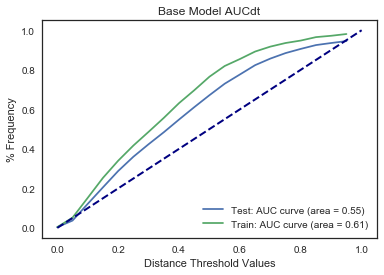

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Running Model for Base Model SMOTE AUCdt
Model Runtime: 00:00:20
Train Score:
[ 0.8727321]
Test Score:
[ 0.69843943]


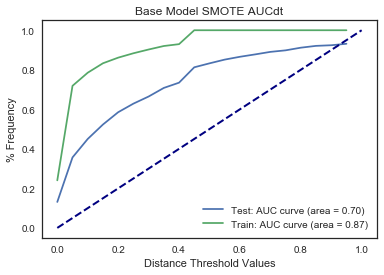

Running Model for Weighted Base Model AUCdt
Model Runtime: 00:00:11
Train Score:
[ 0.80987234]
Test Score:
[ 0.78093766]


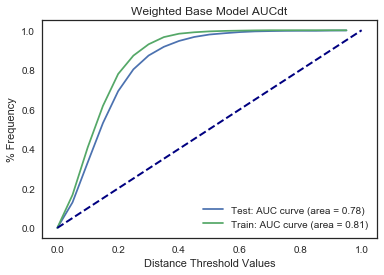

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5655, 5)
Running Model for Weighted Base Model SMOTE AUCdt
Model Runtime: 00:00:20
Train Score:
[ 0.90831123]
Test Score:
[ 0.8308046]


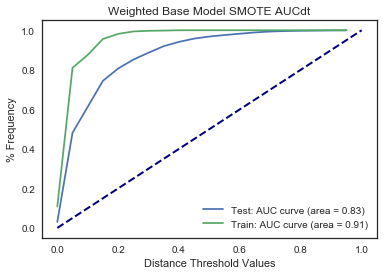

In [22]:
# X = ImageFeatures; y = pMalignancy; smoteFlag = False; mode = mMalignancy
# =====================================================================
# BASE MODEL - AUCdt NO TUNING
# =====================================================================
# Set params for models - if you want to change parameters, change them here

params = [{'name': 'Base Model AUCdt', 'X': ImageFeatures, 'y': pMalignancy,  'mode': mMalignancy, 'smoteFlag': False,  'k': base_optK['Base Model MSE']},
          {'name': 'Base Model SMOTE AUCdt', 'X': ImageFeatures, 'y': pMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': base_optK['Base Model SMOTE MSE']},    
          {'name': 'Weighted Base Model AUCdt', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': False, 'k': base_optK['Weighted Base Model MSE']},
          {'name': 'Weighted Base Model SMOTE AUCdt', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': base_optK['Weighted Base Model SMOTE MSE']}]

names=[]
scores = []
modelnames=[]
scoresTest = []
scoresTrain = []
for param in params:
    # Tune Number of Neighbors
    # use tuning from previous run
    metric = 'AUCdt'
    scoreTest, scoreTrain, predicted, knnTestScores, knnTrainScores = knnModel(param['k'], metric, param['X'], param['y'], param['mode'], maxK, folds, param['smoteFlag'], param['name'])    
    # don't need predicted here    
    plottestscores = np.array(knnTestScores).ravel()
    plottrainscores = np.array(knnTrainScores).ravel()
    plotMe(maxK, [plottestscores,plottrainscores], param['name'], param['name'], metric) 
   
    #plotMe(maxK, plotscores, param['name'], param['name'] + ' Train ', metric) 

Tuning for K
Optimal number of neighbors (mean) is 10
Lowest number of neighbors (mean) is 46
[0.10842126597445752, 0.091389426047005853, 0.086645819394046392, 0.083712159427751218, 0.081889358673401247, 0.080961256861079578, 0.080289403288480582, 0.079727769031293014, 0.079322577658866036, 0.078873791408498858, 0.07862187487671049, 0.078504237790308268, 0.078509029478751227, 0.078440167485502379, 0.078384628807678491, 0.078225908528954613, 0.078073381666061856, 0.078068386692918795, 0.078013068605173874, 0.077968730493497812, 0.077908706709455738, 0.077866897718752839, 0.077801958720567679, 0.077812117248550652]
24


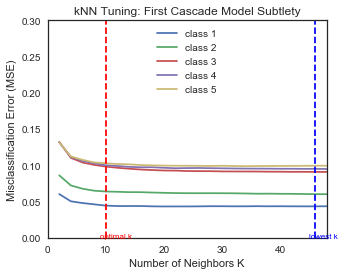

Tuning for K
Optimal number of neighbors (mean) is 10
Lowest number of neighbors (mean) is 48
[0.11149711244126137, 0.09361861252486256, 0.087886973853285949, 0.085621283457054803, 0.083909093460689255, 0.0831252679091775, 0.082396197566898796, 0.081365458331881288, 0.080915104670029755, 0.080455530812312756, 0.080184039551896097, 0.079971931241046942, 0.079611758923338299, 0.079472628217200497, 0.079356211687417383, 0.079084688008131815, 0.079074967028198995, 0.078922456418762568, 0.078859670559956394, 0.078812259357571884, 0.078738844783677597, 0.078704865959542208, 0.078681143046289065, 0.078573714853635124]
24


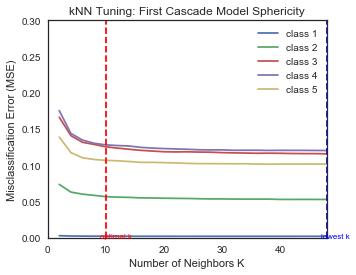

Tuning for K
Optimal number of neighbors (mean) is 8
Lowest number of neighbors (mean) is 36
[0.10698787658894045, 0.090463903130126561, 0.08474526802984253, 0.081932272134233625, 0.080924757743374792, 0.07993308439230426, 0.07957594798671655, 0.079060991114681317, 0.078561929418903373, 0.078501509674913941, 0.078405915893936834, 0.078191126300612132, 0.07791057962498224, 0.077764122604412456, 0.077370751240786712, 0.077163259406963738, 0.077149115169710764, 0.077073162920040378, 0.07710066483475897, 0.077197875926665813, 0.077103838430097646, 0.077164256466228071, 0.077162298466420046, 0.077112037785034795]
24


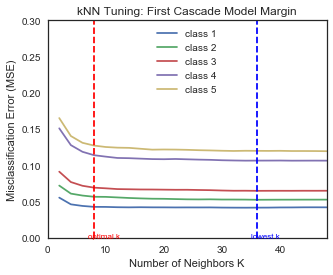

Tuning for K
Optimal number of neighbors (mean) is 10
Lowest number of neighbors (mean) is 48
[0.077757427744129887, 0.063914577182529325, 0.06024723604510842, 0.05837790432953336, 0.057318315745975346, 0.056446301377595723, 0.055921574213204692, 0.055445371750433278, 0.055208508133054987, 0.055037211892398075, 0.054858447199971759, 0.054764076523274231, 0.054550910859216907, 0.054380075230935507, 0.054334029663816931, 0.05433157819544128, 0.05432975716068552, 0.054174520730741173, 0.054135339364423794, 0.054025726235699657, 0.054019938446773011, 0.054019834301507419, 0.053978491157909383, 0.053923887744047883]
24


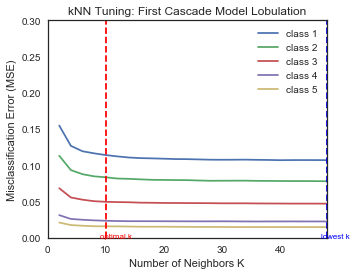

Tuning for K
Optimal number of neighbors (mean) is 10
Lowest number of neighbors (mean) is 48
[0.070495664564813529, 0.057310150325442899, 0.053989536476238643, 0.052460300313525068, 0.051407708025793142, 0.050319899750307581, 0.049820742715608088, 0.049258378101047669, 0.049055878768250696, 0.0488564646506136, 0.048761561909421082, 0.04877916553420765, 0.048553416735699864, 0.048399852351491537, 0.048379915321050085, 0.048343058421079568, 0.048337574212519004, 0.048280829172279133, 0.04828225619309047, 0.048257395195693095, 0.04817342113468543, 0.048177326946422058, 0.048197201696653681, 0.048127556833092083]
24


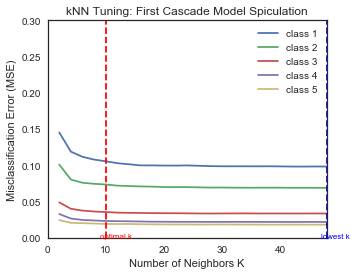

Tuning for K
Optimal number of neighbors (mean) is 8
Lowest number of neighbors (mean) is 24
[0.070499141895418505, 0.059503823430020232, 0.05601400729503566, 0.053968911413226586, 0.053122780088737574, 0.052598396960099089, 0.052374675066001575, 0.052315654299946203, 0.051956989578640457, 0.051881389399208541, 0.051833530321419373, 0.051766964460891761, 0.051812453500260369, 0.05183129563686175, 0.05180541761942474, 0.051903157784245715, 0.051929834738906736, 0.052016199474089544, 0.052061028459220539, 0.052173546107588661, 0.052206651500869186, 0.05228747947294634, 0.052351430959829984, 0.052390174668543475]
24


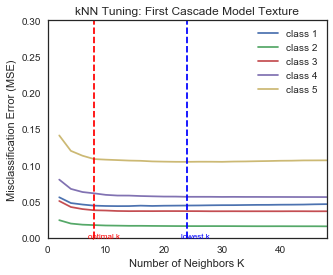

Tuning for K
Optimal number of neighbors (mean) is 20
Lowest number of neighbors (mean) is 28
[0.0021962940679696001, 0.0019713642926741329, 0.0018638511490905113, 0.0018583665660211542, 0.0018434192257330559, 0.0018316827977178146, 0.0018175829234095616, 0.0018031478067735546, 0.0017957683830172005, 0.0017783704020406161, 0.0017814116567303664, 0.001779989742991183, 0.0017773000230037871, 0.0017764927201158465, 0.0017771472396915658, 0.0017772011028275572, 0.001780517637022552, 0.0017784069445687849, 0.0017793067893538651, 0.0017792502350763653, 0.0017799630509275528, 0.0017808007769693961, 0.0017788108943578426, 0.0017798243177267175]
24


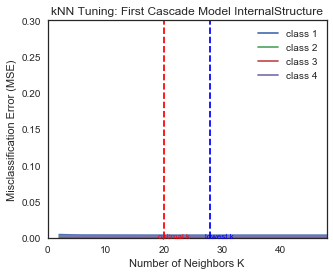

Tuning for K
Optimal number of neighbors (mean) is 12
Lowest number of neighbors (mean) is 16
[0.015308191671223588, 0.013892567724017193, 0.013202392738444748, 0.012883851449759029, 0.012684102467347145, 0.012615208389440071, 0.012664684309685389, 0.012544870742281814, 0.01266496344641866, 0.012679456341357934, 0.012787509141584233, 0.01278791191085258, 0.012831369615841784, 0.012860182560539437, 0.012982311315644646, 0.013066662263725305, 0.013174755633504629, 0.013295957417189698, 0.013322795121654669, 0.01341508846703328, 0.013503424461956794, 0.013535733722192425, 0.013593678662882904, 0.013651117169397134]
24


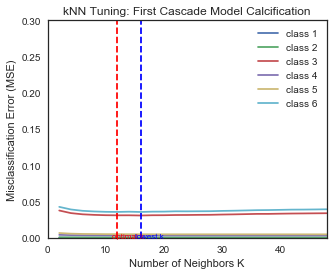

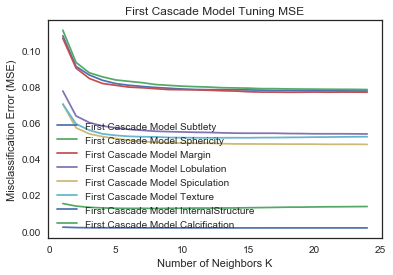

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(4565, 5)
Tuning for K
Optimal number of neighbors (mean) is 2
Lowest number of neighbors (mean) is 2
[0.073857525491841061, 0.085697487471932371, 0.091911143010756285, 0.096204272181300829, 0.099159598532469306, 0.10126057181674916, 0.10278962269758048, 0.1039536228037696, 0.10490684103299583, 0.10575402672851922, 0.10637601880610248, 0.10721705845446565, 0.10772466042152276, 0.10812995866064648, 0.1085274982919846, 0.10876098665777238, 0.10895811029934332, 0.1092558892849373, 0.1094313391313225, 0.1096123077471171, 0.10980004387858164, 0.10997335931054257, 0.1101352699383356, 0.11024866182989816]
24


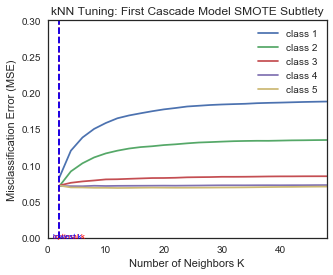

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(4935, 5)
Tuning for K
Optimal number of neighbors (mean) is 2
Lowest number of neighbors (mean) is 2
[0.10440366216241448, 0.11588672580748142, 0.12239289184787087, 0.12648991822020642, 0.12917873286085102, 0.13080373462198386, 0.13241579755284164, 0.13369389865241149, 0.1348307647602765, 0.13605843818903579, 0.13709417960118844, 0.13786628221844918, 0.13867148603990112, 0.13932495982678034, 0.13978656541979192, 0.14025146384327714, 0.14058652412754391, 0.1409731981876069, 0.1414742668333675, 0.14200264980329239, 0.14242033663402603, 0.14278159453418279, 0.1431068518744199, 0.14344026938658902]
24


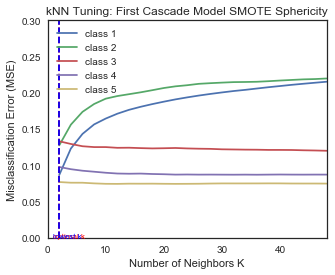

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(5675, 5)
Tuning for K
Optimal number of neighbors (mean) is 2
Lowest number of neighbors (mean) is 2
[0.071180280234281093, 0.082225413434379543, 0.089414025327946886, 0.093637044333349601, 0.096762945242117732, 0.099080192254470179, 0.1008903474717517, 0.10244312907635142, 0.10352004733645859, 0.10442253609810707, 0.10522269419420829, 0.10608743372660907, 0.10669550411431476, 0.10723725442990487, 0.10775330718354914, 0.10823409785212168, 0.10871521139049919, 0.10914344139790921, 0.10953240207250863, 0.10983102204808035, 0.11004484375479166, 0.11032512145893163, 0.11047155628258525, 0.11073998078056051]
24


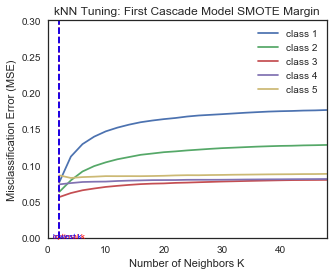

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(7925, 5)
Tuning for K
Optimal number of neighbors (mean) is 2
Lowest number of neighbors (mean) is 2
[0.067636544183929725, 0.080329285223151886, 0.087684503630439489, 0.092536873220549848, 0.09583560684530365, 0.09848777771963553, 0.10029873587673939, 0.10163173731273445, 0.10267721211341083, 0.10353927009169191, 0.10420914149453467, 0.10489238808536232, 0.10527138880354785, 0.10560365230565016, 0.10600575391310996, 0.10627345118326556, 0.1064254793763522, 0.10658964613068626, 0.10671990174217841, 0.10683381871504531, 0.10696379320882383, 0.10700963031953341, 0.10707372931755095, 0.1071220956786669]
24


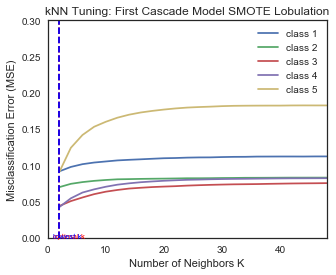

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(8975, 5)
Tuning for K
Optimal number of neighbors (mean) is 2
Lowest number of neighbors (mean) is 2
[0.049556642886834285, 0.057400219958807078, 0.062423122838646802, 0.065859113430605021, 0.068445728272558196, 0.070241160957807511, 0.071866026083938855, 0.073268140571869103, 0.074316520694887603, 0.075419777081667666, 0.076359014695440999, 0.077239319105101956, 0.07806029980391152, 0.078823918368246454, 0.079477092500071123, 0.080042965437670061, 0.080582059163423619, 0.081103036073203738, 0.081558465840645494, 0.082014258751637967, 0.082393288234662965, 0.082784071452299032, 0.083143467643261387, 0.083511046741560568]
24


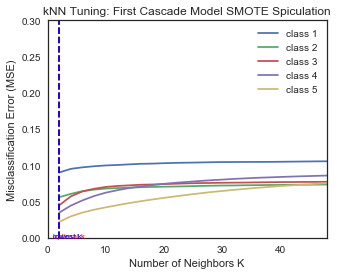

SMOTEing...
Original dataset shape: 
(2588, 5)
New Xy shape
(2588, 69)
Resampled dataset shape: 
(9800, 5)
Tuning for K


In [ ]:
# =====================================================================
# FIRST CASCADE WITH TUNING
# =====================================================================
# Set params for model
metric = 'MSE'
params = [{'name': 'First Cascade Model','X': ImageFeatures, 'y': pSemantic, 'mode': mSemantic,'smoteFlag': False},
          {'name': 'First Cascade Model SMOTE','X': ImageFeatures, 'y': pSemantic, 'mode': mSemantic,'smoteFlag': True},
          {'name': 'Weighted First Cascade Model','X': ImageFeatures, 'y': pwSemantic, 'mode': mSemantic,'smoteFlag': False},
          {'name': 'Weighted First Cascade Model SMOTE','X': ImageFeatures, 'y': pwSemantic, 'mode': mSemantic,'smoteFlag': True}]

# Tune Number of Neighbors
modelsPredicted = []
modelsScoresTest = []
modelsScoresTrain = []
cascade1_optK ={}

for param in params:   
    names=[]
    scores = []
    modelnames=[]
    scoresTest = []
    scoresTrain = []
    allScores = []
    semanticPredicted = dict()
    
    for feature in semanticFeatures:   
        # Tune Number of Neighbors
        k, tuningscores = knnTuning(metric, param['X'], param['y'][feature], param['mode'][feature], maxK, folds, param['smoteFlag'], param['name'] + ' ' + feature,pct_diff)
        scores.append(tuningscores)
        names.append(param['name'] + ' ' + feature)
        semanticPredicted[feature]= k
    plotMe(maxK, scores, names, param['name'] + ' Tuning ' + metric, metric)
    cascade1_optK[param['name']] = semanticPredicted
    
    

In [ ]:
cascade1_optK

In [ ]:
# =====================================================================
# FIRST CASCADE NO TUNING MSE
# =====================================================================
# Set params for model

metric = 'MSE'
params = [{'name': 'First Cascade Model','X': ImageFeatures, 'y': pSemantic, 'mode': mSemantic,'smoteFlag': False},
          {'name': 'First Cascade Model SMOTE','X': ImageFeatures, 'y': pSemantic, 'mode': mSemantic,'smoteFlag': True},
          {'name': 'Weighted First Cascade Model','X': ImageFeatures, 'y': pwSemantic, 'mode': mSemantic,'smoteFlag': False},
          {'name': 'Weighted First Cascade Model SMOTE','X': ImageFeatures, 'y': pwSemantic, 'mode': mSemantic,'smoteFlag': True}]
#Tune Number of Neighbors
modelsPredicted = dict()
modelsScoresTest = dict()
modelsScoresTrain = dict()
k1 = cascade1_optK['First Cascade Model'].values() # trained for First Cascade Model
k2 = cascade1_optK['First Cascade Model SMOTE'].values() # trained for First Cascade Model SMOTE
k3 = cascade1_optK['Weighted First Cascade Model'].values() # trained for Weighted First Cascade Model
k4 = cascade1_optK['Weighted First Cascade Model SMOTE'].values() # trained for Weighted First Cascade Model SMOTE
klist = [k1, k2, k3, k4]
#klist = [k1, k3]
for param, ks in zip(params,klist):   
    names=[]
    scores = []
    modelnames=[]
    scoresTest = []
    scoresTrain = []
    allScores = []
    semanticPredicted = []    
    for k, feature in zip(ks,semanticFeatures):   
        # model
        scoreTest, scoreTrain, predicted, knnTestScores, knnTrainScores = knnModel(k, metric, param['X'], param['y'][feature], param['mode'][feature], maxK, folds, param['smoteFlag'], param['name'] + ' ' + feature)
        scoresTest.append(scoreTest) 
        scoresTrain.append(scoreTrain)         
        semanticPredicted.append(predicted)
        # plotMe(maxK, [scoreTest,scoreTrain], ['test','train'], param['name'] + ' ' + feature + ' ' + metric, metric)
    modelsPredicted[param['name']]=semanticPredicted             
    modelsScoresTest[param['name']]= scoresTest
    modelsScoresTrain[param['name']] = scoresTrain     
    # plotMe(maxK, modelsScoresTest, semanticFeatures, param['name'] + ' ' + feature + ' ' + metric, metric)
    



In [ ]:
# =====================================================================
# FIRST CASCADE NO TUNING AUCdt
# =====================================================================
# Set params for model


maxK = 50
metric = 'AUCdt'
params = [{'name': 'First Cascade Model','X': ImageFeatures, 'y': pSemantic, 'mode': mSemantic,'smoteFlag': False},
          {'name': 'First Cascade Model SMOTE','X': ImageFeatures, 'y': pSemantic, 'mode': mSemantic,'smoteFlag': True},
          {'name': 'Weighted First Cascade Model','X': ImageFeatures, 'y': pwSemantic, 'mode': mSemantic,'smoteFlag': False},
          {'name': 'Weighted First Cascade Model SMOTE','X': ImageFeatures, 'y': pwSemantic, 'mode': mSemantic,'smoteFlag': True}]
#Tune Number of Neighbors
modelsPredicted = dict()
modelsScoresTest = dict()
modelsScoresTrain = dict()
k1 = cascade1_optK['First Cascade Model'].values() # trained for First Cascade Model
k2 = cascade1_optK['First Cascade Model SMOTE'].values() # trained for First Cascade Model SMOTE
k3 = cascade1_optK['Weighted First Cascade Model'].values() # trained for Weighted First Cascade Model
k4 = cascade1_optK['Weighted First Cascade Model SMOTE'].values() # trained for Weighted First Cascade Model SMOTE
klist = [k1, k2, k3, k4]
for param, ks in zip(params,klist):   
    names=[]
    scores = []
    modelnames=[]
    scoresTest = []
    scoresTrain = []
    allScores = []
    semanticPredicted = []    
    for k, feature in zip(ks,semanticFeatures):   
        # model
        scoreTest, scoreTrain, predicted, knnTestScores, knnTrainScores = knnModel(k, metric, param['X'], param['y'][feature], param['mode'][feature], maxK, folds, param['smoteFlag'], param['name'] + ' ' + feature)
        plottestscores = np.array(knnTestScores).ravel()
        plottrainscores = np.array(knnTrainScores).ravel()
        plotMe(maxK, [plottestscores,plottrainscores], param['name'], param['name'] + ' ' + feature, metric)    
        scoresTest.append(scoreTest) 
        scoresTrain.append(scoreTrain)         
        semanticPredicted.append(predicted)
    modelsPredicted[param['name']]=semanticPredicted             
    modelsScoresTest[param['name']]= scoresTest
    modelsScoresTrain[param['name']] = scoresTrain     
    # plotMe(maxK, modelsScoresTest, semanticFeatures, param['name'] + ' ' + feature + ' ' + metric, metric)

    
# =====================================================================
# Concatenate FIRST CASCADE
# =====================================================================
# Set params for model
 
cascade1 = np.concatenate([np.array(i) for i in  modelsPredicted['First Cascade Model']], axis=1)
cascade1_smote = np.concatenate([np.array(i) for i in  modelsPredicted['First Cascade Model SMOTE']], axis=1)
wCascade1 = np.concatenate([np.array(i) for i in modelsPredicted['Weighted First Cascade Model']], axis=1)
wCascade1_smote = np.concatenate([np.array(i) for i in modelsPredicted['Weighted First Cascade Model SMOTE']], axis=1)

print('Cascade1 Shape:',cascade1.shape)    
print('Cascade1_smote Shape:',cascade1_smote.shape)
print('pMalignancy Shape:',pMalignancy.shape)

print('wCascade1 Shape:',wCascade1.shape)
print('wCascade1_smote Shape:',wCascade1_smote.shape)
print('pwMalignancy Shape:',pwMalignancy.shape)

In [ ]:
# =====================================================================
# SECOND CASCADE TUNING
# =====================================================================
# Set params for models - if you want to change parameters, change them here

# X = cascade1; y=pMalignancy; mode=mMalignancy; name='First Cascade Model'; smoteFlag=True;
metric = 'MSE'
params = [{'name': 'Second Cascade Model','X': cascade1, 'y': pMalignancy, 'mode': mMalignancy,'smoteFlag': False},
          {'name': 'Second Cascade Model SMOTE','X': cascade1_smote, 'y': pMalignancy, 'mode': mMalignancy,'smoteFlag': True},
          {'name': 'Weighted Second Cascade Model','X': wCascade1, 'y': pwMalignancy, 'mode': mMalignancy,'smoteFlag': False},
          {'name': 'Weighted Second Cascade Model SMOTE','X': wCascade1_smote, 'y': pwMalignancy, 'mode': mMalignancy,'smoteFlag': True}]
#params = [{'name': 'Second Cascade Model','X': cascade1, 'y': pMalignancy, 'mode': mMalignancy,'smoteFlag': False},
#          {'name': 'Weighted Second Cascade Model','X': wCascade1, 'y': pwMalignancy, 'mode': mMalignancy,'smoteFlag': False}]

names=[]
scores = []
modelnames=[]
scoresTest = []
scoresTrain = []
maxK = 100
cascade2_optK ={}
for param in params:
    # Tune Number of Neighbors
    k, tuningscores = knnTuning(metric, param['X'], param['y'], param['mode'], maxK, folds, param['smoteFlag'], param['name'],pct_diff)
    scores.append(tuningscores)
    names.append(param['name'])
    cascade2_optK[param['name']] = k
plotMe(maxK, scores, names, 'Second Cascade ' + metric, metric)
    

In [ ]:
cascade2_optK

In [ ]:
# =====================================================================
# SECOND CASCADE - MSE NO TUNING
# =====================================================================
#params = [{'name': 'Base Model MSE', 'X': ImageFeatures, 'y': pMalignancy,  'mode': mMalignancy, 'smoteFlag': False, 'k': 38},
#          {'name': 'Base Model SMOTE MSE', 'X': ImageFeatures, 'y': pMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': 4},    
#          {'name': 'Weighted Base Model MSE', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': False, 'k': 38},
#          {'name': 'Weighted Base Model SMOTE MSE', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': 4}]
params = [{'name': 'Second Cascade Model','X': cascade1, 'y': pMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Second Cascade Model']},
          {'name': 'Second Cascade Model SMOTE','X': cascade1, 'y': pMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Second Cascade Model']},
          {'name': 'Weighted Second Cascade Model','X': wCascade1, 'y': pwMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Weighted Second Cascade Model']},
          {'name': 'Weighted Second Cascade Model','X': wCascade1, 'y': pwMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Weighted Second Cascade Model']}]


metric = 'MSE'
names=[]
scores = []
modelnames=[]
scoresTest = []
scoresTrain = []
for param in params:
    # Tune Number of Neighbors - use previously tuned
    scoreTest, scoreTrain, predicted, knnTestScores, knnTrainScores = knnModel(param['k'], metric, param['X'], param['y'], param['mode'], maxK, folds, param['smoteFlag'], param['name'])
    scoresTest.append(knnTestScores) 
    scoresTrain.append(knnTrainScores) 
    names.append(param['name'])
    # don't need predicted here

In [ ]:
  
# =====================================================================
# SECOND CASCADE - AUCdt NO TUNING
# =====================================================================
#params = [{'name': 'Base Model MSE', 'X': ImageFeatures, 'y': pMalignancy,  'mode': mMalignancy, 'smoteFlag': False, 'k': 38},
#          {'name': 'Base Model SMOTE MSE', 'X': ImageFeatures, 'y': pMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': 4},    
#          {'name': 'Weighted Base Model MSE', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': False, 'k': 38},
#          {'name': 'Weighted Base Model SMOTE MSE', 'X': ImageFeatures, 'y': pwMalignancy, 'mode': mMalignancy, 'smoteFlag': True, 'k': 4}]
params = [{'name': 'Second Cascade Model','X': cascade1, 'y': pMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Second Cascade Model']},
          {'name': 'Second Cascade Model SMOTE','X': cascade1, 'y': pMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Second Cascade Model']},
          {'name': 'Weighted Second Cascade Model','X': wCascade1, 'y': pwMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Weighted Second Cascade Model']},
          {'name': 'Weighted Second Cascade Model','X': wCascade1, 'y': pwMalignancy, 'mode': mMalignancy,'smoteFlag': False, 'k': cascade2_optK['Weighted Second Cascade Model']}]

names=[]
scores = []
modelnames=[]
scoresTest = []
scoresTrain = []
for param in params:
    # Tune Number of Neighbors
    # use tuning from previous run
    metric = 'AUCdt'
    scoreTest, scoreTrain, predicted, knnTestScores, knnTrainScores = knnModel(param['k'], metric, param['X'], param['y'], param['mode'], maxK, folds, param['smoteFlag'], param['name'])    
    # don't need predicted here    
    plottestscores = np.array(knnTestScores).ravel()
    plottrainscores = np.array(knnTrainScores).ravel()
    plotMe(maxK, [plottestscores,plottrainscores], param['name'], param['name'], metric) 
   